In [1]:
!pip install dtaidistance numpy pandas matplotlib seaborn scipy scikit-learn tqdm
!pip install numba  
!pip install fastdtw  

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# ## Step 2: Import Libraries

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Clustering and distance metrics
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# DTW specific
from dtaidistance import dtw
from dtaidistance import dtw_ndim

# For large datasets
import multiprocessing as mp
from functools import partial
import time

# Set style for better plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"Number of CPU cores available: {mp.cpu_count()}")

✓ All libraries imported successfully
Number of CPU cores available: 8


DATASET INFORMATION
Shape: (249, 96)
Number of time series: 249
Length of each series: 96
Total data points: 23,904
Memory usage: 0.18 MB

Missing values: 0

STATISTICAL SUMMARY (first 5 time points)
            8327.5       8329.1     8329.1.1       8326.9       8330.5
count   249.000000   249.000000   249.000000   249.000000   249.000000
mean   8423.795984  8423.713253  8423.546185  8423.417671  8423.163052
std     109.299059   109.402311   109.379501   109.687632   109.653127
min    8178.600000  8176.800000  8173.600000  8174.400000  8174.600000
25%    8352.200000  8351.600000  8350.600000  8352.800000  8351.600000
50%    8421.600000  8422.400000  8424.800000  8426.400000  8425.900000
75%    8500.700000  8499.500000  8499.400000  8498.600000  8497.200000
max    8673.500000  8678.200000  8676.800000  8676.800000  8671.200000


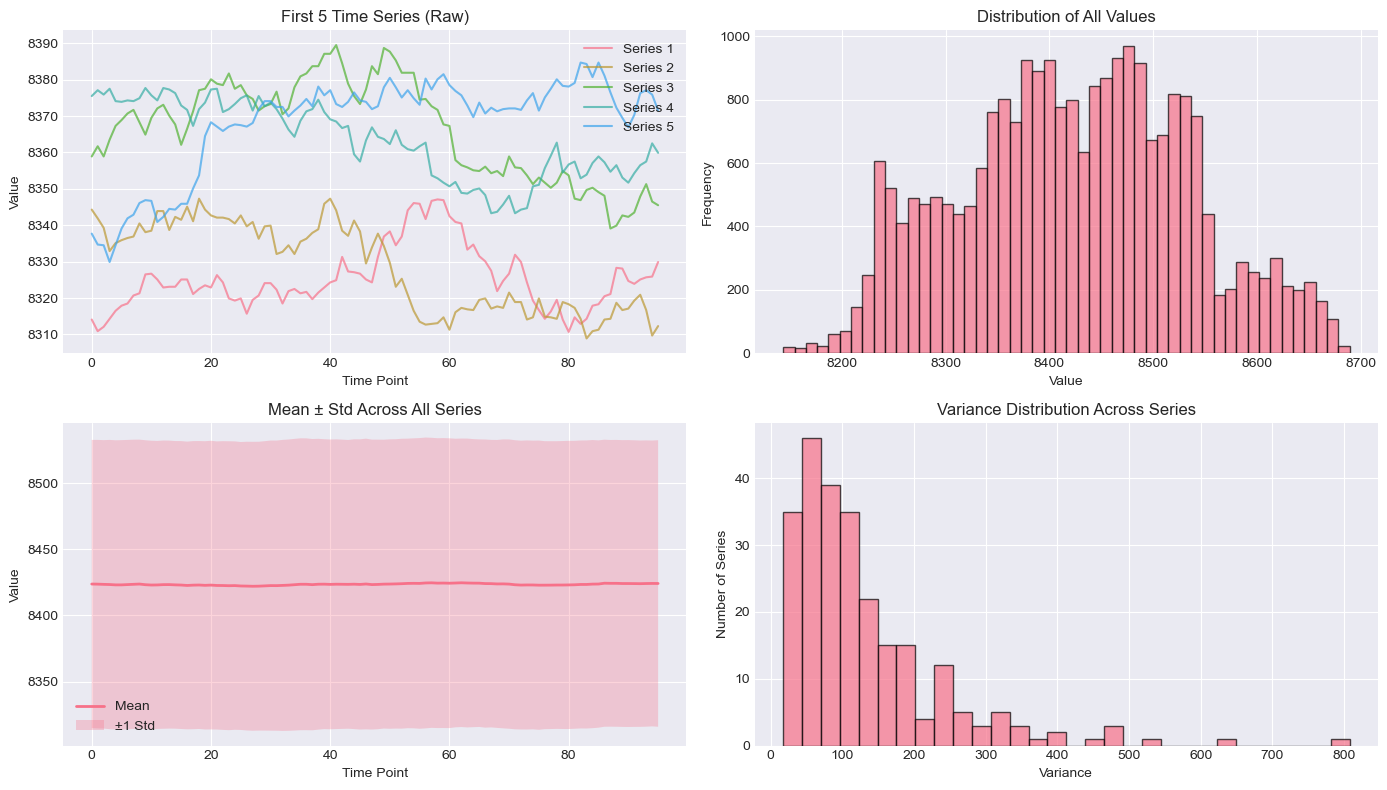

In [3]:
# ## Step 3: Load and Explore Your Data

# %%
def load_and_explore_data(filepath):
    """
    Load time series data and provide basic statistics
    """
    # Load data
    df = pd.read_csv(filepath)
    
    # Basic info
    print("="*60)
    print("DATASET INFORMATION")
    print("="*60)
    print(f"Shape: {df.shape}")
    print(f"Number of time series: {df.shape[0]}")
    print(f"Length of each series: {df.shape[1]}")
    print(f"Total data points: {df.shape[0] * df.shape[1]:,}")
    print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # Check for missing values
    missing = df.isnull().sum().sum()
    print(f"\nMissing values: {missing}")
    
    # Statistical summary
    print("\n" + "="*60)
    print("STATISTICAL SUMMARY (first 5 time points)")
    print("="*60)
    print(df.iloc[:, :5].describe())
    
    # Convert to numpy array for processing
    data_array = df.values
    
    # Visualize sample series
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # Plot first few series
    n_sample = min(5, len(data_array))
    axes[0, 0].set_title(f'First {n_sample} Time Series (Raw)')
    for i in range(n_sample):
        axes[0, 0].plot(data_array[i], alpha=0.7, label=f'Series {i+1}')
    axes[0, 0].legend()
    axes[0, 0].set_xlabel('Time Point')
    axes[0, 0].set_ylabel('Value')
    
    # Distribution of values
    axes[0, 1].set_title('Distribution of All Values')
    axes[0, 1].hist(data_array.flatten(), bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Value')
    axes[0, 1].set_ylabel('Frequency')
    
    # Mean and std across time
    means = np.mean(data_array, axis=0)
    stds = np.std(data_array, axis=0)
    axes[1, 0].set_title('Mean ± Std Across All Series')
    axes[1, 0].plot(means, label='Mean', linewidth=2)
    axes[1, 0].fill_between(range(len(means)), 
                            means - stds, means + stds, 
                            alpha=0.3, label='±1 Std')
    axes[1, 0].legend()
    axes[1, 0].set_xlabel('Time Point')
    axes[1, 0].set_ylabel('Value')
    
    # Variance across series
    variances = np.var(data_array, axis=1)
    axes[1, 1].set_title('Variance Distribution Across Series')
    axes[1, 1].hist(variances, bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('Variance')
    axes[1, 1].set_ylabel('Number of Series')
    
    plt.tight_layout()
    plt.show()
    
    return df, data_array

# Load your data
filepath = "DayByDay96_Step Index.csv"  # Change this to your file
df, data = load_and_explore_data(filepath)

Preprocessing 249 time series...


Normalizing: 100%|█████████████████████████████████████████████████████████████████| 249/249 [00:00<00:00, 1401.82it/s]

✓ Preprocessing complete


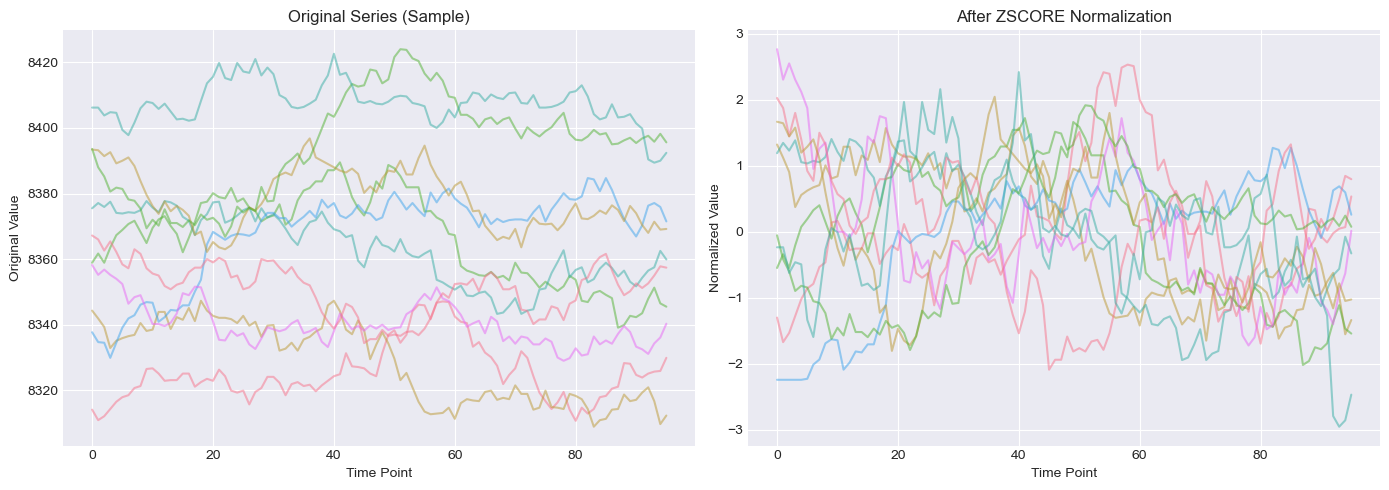

In [4]:
# ## Step 4: Data Preprocessing and Normalization

# %%
def preprocess_time_series(data, method='zscore', handle_outliers=True):
    """
    Preprocess time series data with various normalization options
    
    Parameters:
    -----------
    data : numpy array
        Each row is a time series
    method : str
        'zscore': Z-score normalization (mean=0, std=1)
        'minmax': Min-max scaling to [0,1]
        'robust': Robust scaling using median and IQR
    handle_outliers : bool
        If True, clip extreme outliers
    """
    n_series = len(data)
    processed = np.zeros_like(data)
    
    print(f"Preprocessing {n_series} time series...")
    
    for i in tqdm(range(n_series), desc="Normalizing"):
        series = data[i].copy()
        
        # Handle outliers if requested
        if handle_outliers:
            q1, q3 = np.percentile(series, [25, 75])
            iqr = q3 - q1
            lower = q1 - 3 * iqr
            upper = q3 + 3 * iqr
            series = np.clip(series, lower, upper)
        
        # Apply normalization
        if method == 'zscore':
            mean = np.mean(series)
            std = np.std(series)
            if std > 0:
                processed[i] = (series - mean) / std
            else:
                processed[i] = series - mean
                
        elif method == 'minmax':
            min_val = np.min(series)
            max_val = np.max(series)
            if max_val > min_val:
                processed[i] = (series - min_val) / (max_val - min_val)
            else:
                processed[i] = series - min_val
                
        elif method == 'robust':
            median = np.median(series)
            q1, q3 = np.percentile(series, [25, 75])
            iqr = q3 - q1
            if iqr > 0:
                processed[i] = (series - median) / iqr
            else:
                processed[i] = series - median
    
    print("✓ Preprocessing complete")
    
    # Visualize normalization effect
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Sample series before and after
    n_show = min(10, n_series)
    
    axes[0].set_title('Original Series (Sample)')
    for i in range(n_show):
        axes[0].plot(data[i], alpha=0.5)
    axes[0].set_xlabel('Time Point')
    axes[0].set_ylabel('Original Value')
    
    axes[1].set_title(f'After {method.upper()} Normalization')
    for i in range(n_show):
        axes[1].plot(processed[i], alpha=0.5)
    axes[1].set_xlabel('Time Point')
    axes[1].set_ylabel('Normalized Value')
    
    plt.tight_layout()
    plt.show()
    
    return processed

# Preprocess your data
normalized_data = preprocess_time_series(data, method='zscore', handle_outliers=True)

In [5]:
# ## Step 5: Efficient DTW Distance Computation for Large Datasets
# ### Using parallel processing and optimization techniques

# %%
def compute_dtw_distance_batch(indices, data, window, use_prunning):
    """
    Compute DTW distances for a batch of index pairs
    """
    distances = []
    for i, j in indices:
        if window:
            dist = dtw.distance_fast(data[i], data[j], window=window, use_pruning=use_prunning)
        else:
            dist = dtw.distance_fast(data[i], data[j], use_pruning=use_prunning)
        distances.append((i, j, dist))
    return distances

def compute_dtw_matrix_parallel(data, window_ratio=0.1, n_jobs=-1, sample_size=None):
    """
    Compute DTW distance matrix with parallel processing
    
    Parameters:
    -----------
    data : numpy array
        Normalized time series data
    window_ratio : float
        Sakoe-Chiba window as ratio of series length (0.1 = 10%)
    n_jobs : int
        Number of parallel jobs (-1 for all cores)
    sample_size : int or None
        If provided, randomly sample this many series for faster computation
    """
    # Sample if requested
    if sample_size and sample_size < len(data):
        print(f"Sampling {sample_size} series from {len(data)} total...")
        indices = np.random.choice(len(data), sample_size, replace=False)
        data = data[indices]
    
    n_series = len(data)
    series_length = data.shape[1]
    
    # Calculate window size
    window = int(window_ratio * series_length) if window_ratio else None
    
    print(f"Computing DTW distances for {n_series} series...")
    print(f"Series length: {series_length}")
    print(f"Window size: {window if window else 'No constraint'}")
    print(f"Total comparisons: {n_series * (n_series - 1) // 2:,}")
    
    # For very large datasets, use lower triangular computation
    distance_matrix = np.zeros((n_series, n_series))
    
    # Generate all pairs to compute
    pairs = [(i, j) for i in range(n_series) for j in range(i + 1, n_series)]
    
    # Compute distances with progress bar
    start_time = time.time()
    
    if n_series < 100:  # Small dataset - simple loop
        for i, j in tqdm(pairs, desc="Computing DTW"):
            dist = dtw.distance_fast(data[i], data[j], 
                                    window=window, 
                                    use_pruning=True)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist
            
    else:  # Large dataset - use batching
        batch_size = 1000
        for batch_start in tqdm(range(0, len(pairs), batch_size), 
                                desc="DTW Batches"):
            batch_end = min(batch_start + batch_size, len(pairs))
            batch_pairs = pairs[batch_start:batch_end]
            
            for i, j in batch_pairs:
                dist = dtw.distance_fast(data[i], data[j], 
                                        window=window, 
                                        use_pruning=True)
                distance_matrix[i, j] = dist
                distance_matrix[j, i] = dist
    
    elapsed_time = time.time() - start_time
    print(f"✓ Distance computation complete in {elapsed_time:.2f} seconds")
    print(f"Average time per comparison: {elapsed_time / len(pairs):.4f} seconds")
    
    return distance_matrix

# For large datasets, you might want to sample first
sample_size = min(200, len(normalized_data))  # Adjust based on your needs

# Compute distance matrix
dist_matrix = compute_dtw_matrix_parallel(
    normalized_data,
    window_ratio=0.1,  # 10% window for efficiency
    sample_size=sample_size if len(normalized_data) > 200 else None
)

Sampling 200 series from 249 total...
Computing DTW distances for 200 series...
Series length: 96
Window size: 9
Total comparisons: 19,900


DTW Batches: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 27.31it/s]

✓ Distance computation complete in 0.74 seconds
Average time per comparison: 0.0000 seconds


Evaluating different cluster numbers...


Testing clusters: 100%|█████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 317.86it/s]


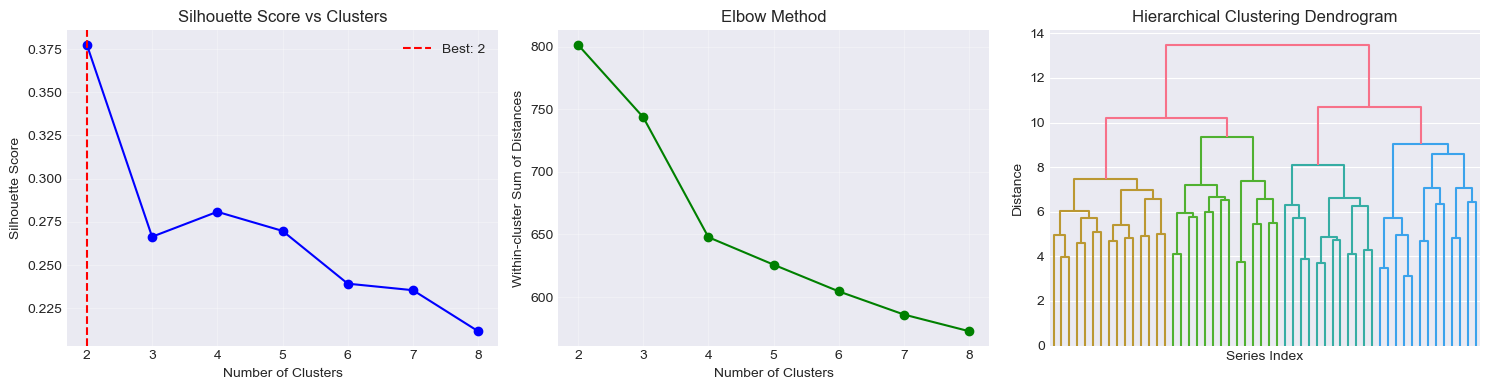


📊 CLUSTERING METRICS SUMMARY
Clusters:  2 | Silhouette:  0.377 | Inertia:   801.41
Clusters:  3 | Silhouette:  0.266 | Inertia:   743.59
Clusters:  4 | Silhouette:  0.281 | Inertia:   647.81
Clusters:  5 | Silhouette:  0.270 | Inertia:   625.89
Clusters:  6 | Silhouette:  0.239 | Inertia:   604.56
Clusters:  7 | Silhouette:  0.235 | Inertia:   586.07
Clusters:  8 | Silhouette:  0.212 | Inertia:   572.77
Recommended clusters (by Silhouette): 2


In [6]:
# ## Step 6: Optimal Number of Clusters Detection

# %%
def find_optimal_clusters(distance_matrix, max_clusters=10):
    """
    Find optimal number of clusters using multiple metrics
    """
    n_series = len(distance_matrix)
    max_clusters = min(max_clusters, n_series - 1)
    
    # Prepare for hierarchical clustering
    condensed_dist = squareform(distance_matrix)
    linkage_matrix = linkage(condensed_dist, method='average')
    
    # Calculate metrics for different cluster numbers
    silhouette_scores = []
    inertias = []
    
    cluster_range = range(2, max_clusters + 1)
    
    print("Evaluating different cluster numbers...")
    for n_clusters in tqdm(cluster_range, desc="Testing clusters"):
        # Get cluster assignments
        clusters = fcluster(linkage_matrix, n_clusters, criterion='maxclust')
        
        # Silhouette score
        if n_clusters < n_series:
            score = silhouette_score(distance_matrix, clusters, metric='precomputed')
            silhouette_scores.append(score)
        else:
            silhouette_scores.append(-1)
        
        # Within-cluster sum of distances (inertia)
        inertia = 0
        for c in range(1, n_clusters + 1):
            mask = clusters == c
            if np.sum(mask) > 1:
                cluster_distances = distance_matrix[mask][:, mask]
                inertia += np.sum(cluster_distances) / (2 * np.sum(mask))
        inertias.append(inertia)
    
    # Plot metrics
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Silhouette scores
    axes[0].plot(cluster_range, silhouette_scores, 'bo-')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('Silhouette Score')
    axes[0].set_title('Silhouette Score vs Clusters')
    axes[0].grid(True, alpha=0.3)
    best_silhouette = np.argmax(silhouette_scores) + 2
    axes[0].axvline(x=best_silhouette, color='r', linestyle='--', 
                   label=f'Best: {best_silhouette}')
    axes[0].legend()
    
    # Elbow plot
    axes[1].plot(cluster_range, inertias, 'go-')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Within-cluster Sum of Distances')
    axes[1].set_title('Elbow Method')
    axes[1].grid(True, alpha=0.3)
    
    # Dendrogram
    axes[2].set_title('Hierarchical Clustering Dendrogram')
    dendrogram(linkage_matrix, ax=axes[2], no_labels=True, 
              truncate_mode='level', p=5)
    axes[2].set_xlabel('Series Index')
    axes[2].set_ylabel('Distance')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 CLUSTERING METRICS SUMMARY")
    print("="*50)
    for i, n in enumerate(cluster_range):
        print(f"Clusters: {n:2d} | Silhouette: {silhouette_scores[i]:6.3f} | "
              f"Inertia: {inertias[i]:8.2f}")
    print("="*50)
    print(f"Recommended clusters (by Silhouette): {best_silhouette}")
    
    return best_silhouette, linkage_matrix, silhouette_scores

# Find optimal clusters
optimal_k, linkage_mat, scores = find_optimal_clusters(dist_matrix, max_clusters=8)